## Combine all 10X output, subset to B cells, and further preprocess to remove apparently ambient droplets

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import scanpy.external as sce
import matplotlib.pyplot as plt
import pathlib
import os
from scipy import stats
import seaborn as sns

import anndata as ad

import celltypist
from celltypist import models

from copy import deepcopy
from glob import glob

Recluster the data after removing cells at various points:

In [2]:
def recluster(adata, batch_correct, n_neighbors=20, batch_key='sample_uid'):
    print('pca-ing')
    sc.pp.pca(adata)
    print("constructing neighbors graph")
    if batch_correct == True:
        sce.pp.bbknn(adata, batch_key=batch_key)
    else:
        sc.pp.neighbors(adata, n_neighbors=n_neighbors)
    print("calculating umap")
    sc.tl.umap(adata)
    sc.tl.leiden(adata, resolution=0.2)
    print("done!")
    return adata

Import data

pca-ing
constructing neighbors graph


/Users/ivanacvijovic/miniconda3/envs/sc2/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


calculating umap


... storing 'sample_uid' as categorical
... storing 'donor' as categorical


done!


... storing 'sample_type' as categorical
... storing 'sample_descriptor' as categorical
... storing 'tissue' as categorical
... storing 'sample_index' as categorical
... storing 'celltypist' as categorical


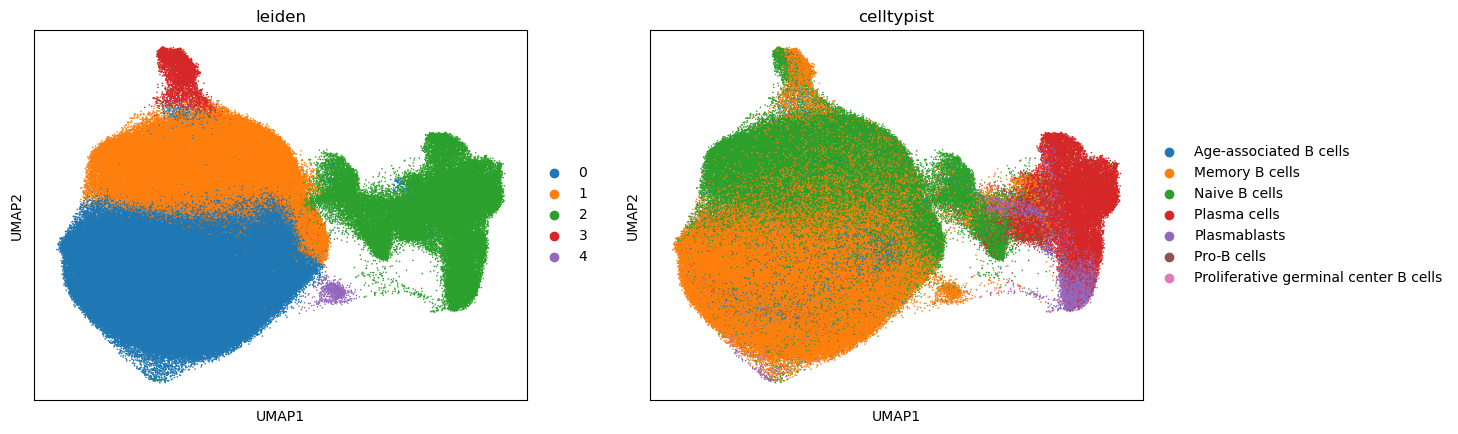

In [3]:


adata_list = []

for donor in ['TBd6','TBd3','TBd5','TBd4', 'TBd1', 'TBd2']:

    for filename in glob('../data/preprocessed/{}*'.format(donor)):
#         print(filename)
        sample_uid=filename.split("/")[-1]
        sample_uid=sample_uid.split(".")[0]
        adata = sc.read_h5ad(filename)
        adata.obs["sample_uid"] = sample_uid
        adata.obs_names_make_unique()
        adata.var_names_make_unique()
        adata_list.append(adata)

adata = ad.concat(adata_list)
adata = adata[adata.obs['celltypist'].str.contains("B cells|Plasma")]
adata.obs_names = adata.obs.sample_uid.astype(str) + "_" + adata.obs_names


adata = recluster(adata, batch_correct=True, n_neighbors=10)
sc.pl.umap(adata, color=['leiden', 'celltypist'],size=5)


The cells labeled Naive in Leiden cluster 2 are almost certainly ambient droplets:
- their gene expression is characterized by a large number of myeloid genes
- their VDJs tend to be highly hypermutated and highly expressed
- and their exact VDJ sequence is almost always found in another celltype

We will label them as ambient here so that these VDJs can also be removed from VDJ cell calls.


In [ ]:
adata.obs['ambient'] = ((adata.obs['celltypist']=='Naive B cells')
                        &(adata.obs['leiden']=='2')).astype(bool)
adata.write_h5ad('../data/pre_decontX/all_B_cells_firstpass.h5ad.gz', compression = 'gzip')

At this point, we want to recluster the data and revisit celltypist labels, since those are dependent on neighbor calls, which may have included ambient droplets.

In [ ]:
print('reading')
adata = sc.read_h5ad('../data/pre_decontX/all_B_cells_firstpass.h5ad.gz')
namb = adata[~adata.obs.ambient]
print('clustering')
namb = recluster(namb, batch_correct=True, n_neighbors=10)
print('plotting')
sc.pl.umap(namb, color=['leiden', 'celltypist'],size=8)


In [ ]:
namb.write_h5ad('../data/pre_decontX/all_B_cells_firstpass_ambient_filtered.h5ad.gz', compression = 'gzip')

Re-annotate new object with celltypist, and save the confidence scores:

In [ ]:
# Re-annotate new object
anno_1 = "celltypist_new"
models.download_models()
predictions = celltypist.annotate(
    namb, model="Immune_All_Low.pkl", majority_voting=True
)

namb.obs[anno_1] = predictions.predicted_labels.majority_voting
namb = predictions.to_adata(insert_labels = True, insert_conf = True)

fig, ax = plt.subplots()
for label in namb.obs.celltypist_new.unique():
    print(label)
    vals = namb[namb.obs.celltypist_new==label].obs.conf_score
    counts, bins = np.histogram(vals, bins= np.linspace(0,1,100))
    ax.plot(bins[1:], np.cumsum(counts)/counts.sum(), label=label)
# ax.set_yscale('log')
ax.axvline(0.85, color='k')
# ax.set_xscale('log')
ax.legend(bbox_to_anchor=(1,1))

Visualize high confidence calls:

In [ ]:
low_prob = namb.obs.conf_score < 0.9
sc.pl.umap(namb[~(low_prob).astype(bool)], color=['celltypist_new'],size=8)
sc.pl.umap(namb[~(low_prob).astype(bool)], color=['tissue'],size=8)
sc.pl.umap(namb[~(low_prob).astype(bool)], color=['donor'])

Write to disk:

In [ ]:
print('writing h5ad')
namb.write_h5ad('../data/pre_decontX/all_B_cells_ambient_filtered_with_conf.h5ad.gz', compression = 'gzip')